<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

from PIL import Image

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 150

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [39]:
os.system("kaggle datasets download -p " + DIR + " --unzip balalexv/fruits-vegetables-photos")

0

In [0]:
#shutil.rmtree(DIR)

In [40]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)

for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  cnt_all = 0
  cnt_v = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cnt_all += 1
    if (np.random.randint(1, 11) == 1):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))
      cnt_v += 1
  print(f'{class_name}: VAL = {cnt_v}, ALL = {cnt_all}, PRC = {(cnt_v / cnt_all * 100):.4}')

cucumber_prickly: VAL = 65, ALL = 688, PRC = 9.448
sultana: VAL = 63, ALL = 549, PRC = 11.48
tomato_plum: VAL = 53, ALL = 555, PRC = 9.55
pepper_red: VAL = 12, ALL = 128, PRC = 9.375
bananas: VAL = 72, ALL = 707, PRC = 10.18
orange: VAL = 5, ALL = 62, PRC = 8.065
grape_black: VAL = 26, ALL = 218, PRC = 11.93
granny_smith: VAL = 38, ALL = 439, PRC = 8.656
lady_fingers: VAL = 14, ALL = 179, PRC = 7.821
grapefruit_yellow: VAL = 23, ALL = 202, PRC = 11.39
lemon: VAL = 75, ALL = 753, PRC = 9.96
mandarin: VAL = 18, ALL = 128, PRC = 14.06
pepper_yellow: VAL = 20, ALL = 174, PRC = 11.49
gala: VAL = 71, ALL = 591, PRC = 12.01
golden: VAL = 24, ALL = 285, PRC = 8.421


In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(0.5,0.5,0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


In [0]:
def show_input(input_tensor, title='', normalize = True):
    image = input_tensor.permute(1, 2, 0).numpy()
    if normalize:
      image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


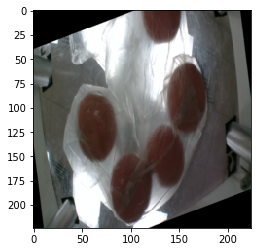

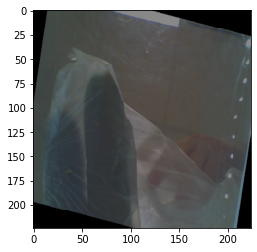

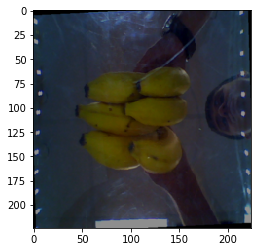

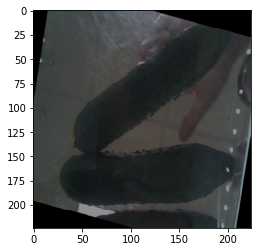

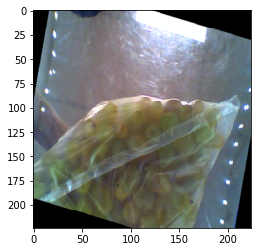

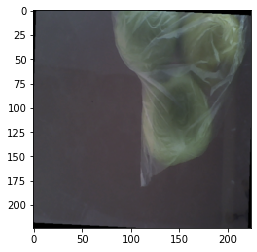

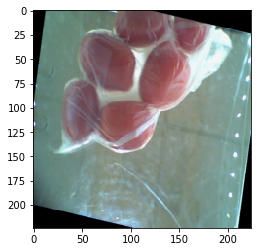

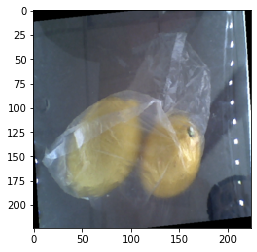

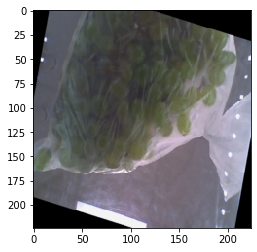

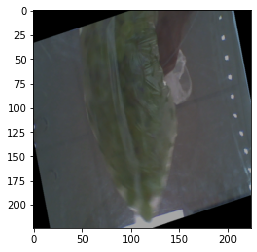

In [44]:
i = 0
n = 10

for inputs, labels in train_dataloader:
  for img in inputs:
    show_input(img)
    i += 1
    if i >= n:
      break
  if i >= n:
    break



In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  hist = {'Train loss': [],'Train acc': [],'Val loss': [],'Val acc': []}
  type_trains = ['Train','Val']
  for epoch in range(num_epochs):
    # Train
    for id_type_train in range(2):
      print(type_trains[id_type_train])
      running_loss = 0.
      running_acc = 0.
      if (id_type_train == 0):
        model.train()
      else:
        model.eval()
      for inputs, labels in tqdm(train_dataloader):
      #for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(id_type_train == 0):
          preds = model(inputs)
          loss_batch = loss(preds, labels)
          preds_class = preds.argmax(dim=1)
          loss_batch.backward()
          optimizer.step()
          loss += loss_batch.item()
          acc += (preds_class == labels.data).float().mean()
      
      loss /= len(train_dataloader)
      acc /= len(train_dataloader)
      if (id_type_train == 0):
        scheduler.step(loss)
        hist['Train loss'].append(loss)
        hist['Train acc'].append(acc)
      else:
        hist['Val loss'].append(loss)
        hist['Val acc'].append(acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train: Loss: {hist['Train loss'][-1]:.4f}, Acc: {hist['Train acc'][-1]:.4f}   Val: Loss: {hist['Val loss'][-1]:.4f}, Acc: {hist['Val acc'][-1]:.4f}")

  return model, hist

In [0]:
cl_cnt = {}
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  cl_cnt[class_name] = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cl_cnt[class_name] += 1

In [0]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

#model.fc = torch.nn.Sequential(
#    torch.nn.Linear(model.fc.in_features, 512),
#    torch.nn.ReLU(),
#    torch.nn.Dropout(0.4),
#    torch.nn.Linear(512, len(train_dataset.classes))
#    , torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
#)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(weight=cl_weight.float())
#loss = torch.nn.NLLLoss(weight=cl_weight.float())

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2, weight_decay = 0.05, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=5, threshold= 0.001, verbose=True)

In [0]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=5);

Epoch 0/4: Train: Loss: 6.2369, Acc: 0.2598   Val: Loss: 1.3908, Acc: 0.6119
Epoch 1/4: Train: Loss: 0.7186, Acc: 0.7544   Val: Loss: 0.3692, Acc: 0.8777
Epoch 2/4: Train: Loss: 0.4754, Acc: 0.8587   Val: Loss: 0.3253, Acc: 0.9133
Epoch 3/4: Train: Loss: 0.4518, Acc: 0.8824   Val: Loss: 0.4436, Acc: 0.8843
Epoch 4/4: Train: Loss: 0.4888, Acc: 0.8787   Val: Loss: 0.3663, Acc: 0.9139


In [0]:
plt.plot(hist['Train loss'][0:])
plt.plot(hist['Val loss'][0:])
plt.show()

plt.plot(hist['Train acc'][0:])
plt.plot(hist['Val acc'][0:])
plt.show()


In [0]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=117, shuffle=False, num_workers=8)

In [0]:
model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()

print(running_acc.item() / 117, 117 - running_acc.item())

0.7606837606837606 28.0


In [0]:
for i in range(inputs.size()[0]):
  if (preds_class[i] != labels.data[i]):
    show_input(inputs[i].cpu(), train_dataset.classes[preds_class[i]])


In [0]:
(224 -56) // 50

3

In [0]:
!nvidia-smi

Mon Feb  3 13:01:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    39W /  70W |   2907MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
plt.colorbar

In [0]:
#show_input(inputs[100].cpu(), )
#plt.colorbar(inputs[100].cpu())


In [0]:
def Occlusion(model, img, class_id, batch_size = 32, size_square = 20, size_step = 5):
  img = img.view([1] + list(img.size()))
  len_row = img.size()[2] // size_step + 1
  len_col = img.size()[3] // size_step + 1
  confidence_predict = []
  i = 0
  j = 0

  for num_batcn in range(1, (len_row * len_col) // batch_size + 2):
    cnt_img = batch_size - max(0,num_batcn * batch_size - (len_row * len_col))
    imgs = torch.cat([img for i in range(cnt_img)])  
    for num_img in range(cnt_img):
      imgs[num_img, :, i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] *= 0
      j += 1
      if (j == len_col):
        i += 1
        j = 0 
    confidence_predict = np.concatenate([confidence_predict ,list(torch.nn.functional.softmax(model(imgs).data ,dim=1)[:,class_id].cpu().numpy())])


  new_img = torch.zeros(img.size()[2:])
  new_img_cnt = torch.zeros(img.size()[2:])

  #print(confidence_predict.min(), confidence_predict.max())
  for i in range(len_row):
    for j in range(len_col):
      new_img[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += confidence_predict[i* len_row + j]
      new_img_cnt[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += 1

  new_img /= new_img_cnt
  #show_input(img[0].cpu())
  #new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min())
  #show_input(torch.cat([1-new_img.view([1] + list(img.size()[2:])), torch.zeros([1] + list(img.size()[2:])), new_img.view([1] + list(img.size()[2:]))]), normalize=False)
  #img_Saliency
  img2 = img.clone()
  img2.requires_grad = True

  img = img[0].cpu().permute(1, 2, 0).numpy()
  img = STD * img + MEAN
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
  fig.set(facecolor = 'white')
  axes[0].imshow(img.clip(0, 1))
  axes[0].set(title = 'Original', xticks=[], yticks=[])


  im = axes[2].imshow(new_img, cmap='RdBu')
  axes[2].set(title = 'Occlusion', xticks=[], yticks=[])
  fig.colorbar(im, ax=axes.ravel().tolist())
  
  
  optimizer = torch.optim.Adam([img2], lr=1.0e-1, weight_decay = 0.05, amsgrad=True)
  optimizer.zero_grad()
  loss_value = loss(model(img2), torch.tensor([class_id]).to(device))
  loss_value.backward()
  optimizer.step()
  new_img = -img2.grad.abs().sum(dim=(0,1)).cpu()
  new_img = new_img - new_img.median() / 2
  new_img = new_img.data.relu()
  im2 = axes[1].imshow(new_img)
  axes[1].set(title = 'Saliency', xticks=[], yticks=[])
 
  plt.show()



    #plt.imshow(image.clip(0, 1))
    #plt.title(title)
    
    #plt.pause(0.001)


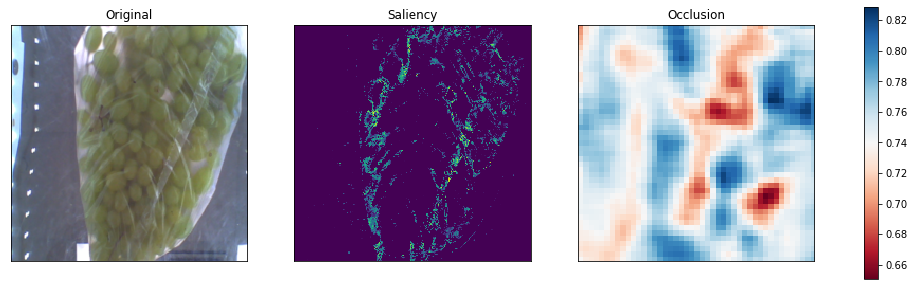

In [0]:
num_photo = 99
img = inputs[num_photo]
class_id = labels[num_photo].item()
Occlusion(model, img, class_id, batch_size = 150, size_square = 20, size_step = 5)


In [0]:
class_id

8

In [0]:
train_dataset.class_to_idx #class_id

{'bananas': 0,
 'cucumber_prickly': 1,
 'gala': 2,
 'golden': 3,
 'granny_smith': 4,
 'grape_black': 5,
 'grapefruit_yellow': 6,
 'lady_fingers': 7,
 'lemon': 8,
 'pepper_red': 9,
 'pepper_yellow': 10,
 'sultana': 11,
 'tomato_plum': 12}

In [0]:
img.size()

torch.Size([3, 224, 224])

In [0]:
img2 = img.clone()

In [0]:
model(img2.view([1] + list(img2.size())))


tensor([[1.4911, 3.4375, 0.1612, 1.9707, 3.9023, 2.5835, 6.6209, 1.0189, 5.7612,
         3.5367, 5.2871, 1.8684, 1.3241]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [0]:
model.fc.weight.min(), model.fc.weight.max(), model.fc.weight.sum()


(tensor(-0.0834, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1768, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(84.8332, device='cuda:0', grad_fn=<SumBackward0>))

In [0]:
model.fc.weight.requires_grad = False

In [0]:
for p in model.parameters():
  p.requires_grad = False


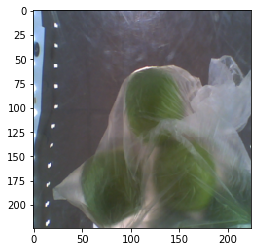

In [0]:
show_input(img2.cpu())

In [0]:
img2.requires_grad = True

In [0]:
  optimizer = torch.optim.Adam([img2], lr=1.0e-1, weight_decay = 0.05, amsgrad=True)

#for i in range(10):
  optimizer.zero_grad()
  loss_value = loss(model(img2.view([1] + list(img2.size()))), torch.tensor([class_id]).to(device))
  #if i % 20 == 0:
  print(loss_value.item(), model(img2.view([1] + list(img2.size())))[0][class_id].item())
  loss_value.backward()
  optimizer.step()


0.8318443298339844 6.514466285705566


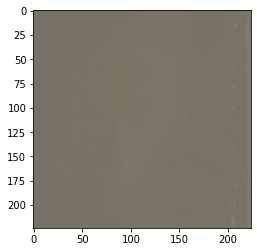

In [0]:
show_input(img2.grad.cpu())

In [0]:
model.fc.weight.min(), model.fc.weight.max(), model.fc.weight.sum()


(tensor(-0.0834, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.1768, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(84.8332, device='cuda:0', grad_fn=<SumBackward0>))

In [0]:
model(img2.view([1] + list(img2.size())))

tensor([[ 2.9347,  3.0958,  4.6605,  0.5350,  2.7228,  0.6466,  4.2762,  2.5695,
         10.6232,  3.4375,  6.0315,  4.4429,  4.8213]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [0]:
img2.grad.sum(dim=0)

tensor([[ 0.3446,  0.2843,  0.2601,  ...,  0.1460,  0.1539,  0.1435],
        [ 0.3541,  0.3033,  0.2653,  ...,  0.1426,  0.1348,  0.1322],
        [ 0.3592,  0.3180,  0.2714,  ...,  0.1253,  0.1176,  0.1114],
        ...,
        [-0.0124, -0.0324, -0.0420,  ...,  0.3644,  0.3644,  0.3644],
        [-0.0359, -0.0420, -0.0455,  ...,  0.3644,  0.3644,  0.3644],
        [-0.0455, -0.0498, -0.0516,  ...,  0.3644,  0.3644,  0.3644]],
       device='cuda:0')

In [0]:
img2.grad

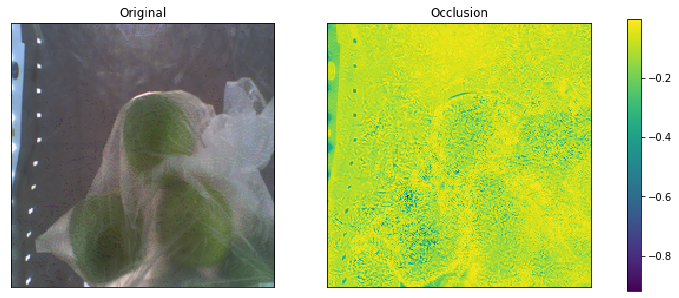

In [0]:
new_img = -img2.grad.abs().sum(dim=0).cpu()

img2 = img2.cpu().permute(1, 2, 0).numpy()
img2 = STD * img2 + MEAN
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.set(facecolor = 'white')
axes[0].imshow(img2.clip(0, 1))
axes[0].set(title = 'Original', xticks=[], yticks=[])
im = axes[1].imshow(new_img)
axes[1].set(title = 'Occlusion', xticks=[], yticks=[])
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()


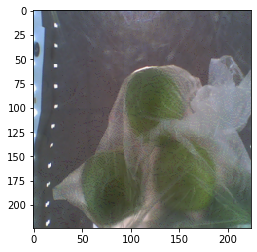

In [0]:
img2.requires_grad = False
show_input(img2.cpu())


In [0]:
print(new_img.median())
new_img = new_img - new_img.median() / 2
#new_img.max()

new_img = new_img.data.relu()


tensor(-0.0876)


In [0]:
#new_img.kthvalue(k=5, dim=(1)).values


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

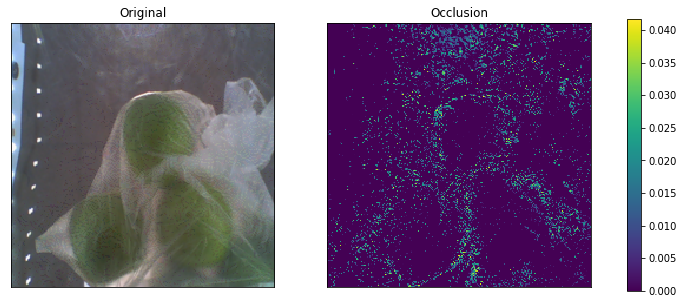

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.set(facecolor = 'white')
axes[0].imshow(img2.clip(0, 1))
axes[0].set(title = 'Original', xticks=[], yticks=[])
im = axes[1].imshow(new_img)
axes[1].set(title = 'Occlusion', xticks=[], yticks=[])
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()
